# Рекомендательная система на базе датасета **movielens**

Один из наиболее известных датасетов в мире рекомендательных систем - Movielens 25M, содержащий рейтинги к фильмам, оставленные различными пользователями на одноименном сайте https://movielens.org/.

Мы будем использовать мини-версию датасета, содержащую 100 тысяч записей рейтингов фильмов.

## Загрузка данных

Для создания алгоритмов рекомендательной системы, будем использовать библиотеку **surprise**.

Установим её, если она ещё не установлена на компьютер.

In [1]:
!pip install scikit-surprise

In [2]:
from surprise import Dataset

Загружаем датасет из **surprise**

In [3]:
data = Dataset.load_builtin("ml-100k", prompt=False)

**Замечание для любителей настоящих данных**

Вы можете попробовать загрузить полную верисю датасета (`'ml-1m'`) и попробовать сделать задание на нём.

Но вычисления будут занимать большее количество времени (и требовать некоторого железа).

За использование расширенного датасета не будет бонусов в оценке (да и результатах по большей части тоже) - только ваш энтузиазм.

## Визуализация данных

Для удобной работы с данными загрузим библиотеку **pandas**

In [4]:
import pandas as pd

Преобразуем данные к формату **pandas DataFrame**, для удобной работы с ними:

In [5]:
df = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "timestamp"])

In [6]:
df.head(10)

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
5,298,474,4.0,884182806
6,115,265,2.0,881171488
7,253,465,5.0,891628467
8,305,451,3.0,886324817
9,6,86,3.0,883603013


*  Колонка **userId** - идентификаторы пользователей сайта movielens;
*  Колонка **movieId** - идентификаторы фильмов;
*  Колонка **rating** - оценки фильмов пользователями по шкале от 1 до 5;
*  Колонка **timestamp** - это время оценки фильма пользователем. Данный формат представления времени показывает, сколько секунд прошло с 1 января 1970 года.

Мы можем посмотреть, сколько уникальных значений находится в каждой из колонок.

In [7]:
df.apply("nunique")

userId         943
movieId       1682
rating           5
timestamp    49282
dtype: int64

Для корректной работы с графиками в python требуется загрузить специальную библиотеку
**matplotlib**, программную библиотеку на языке python для визуализации данных двумерной и трехмерной графикой.

Посмотрим наглядно, как часто в датасете встречаются разные оценки:

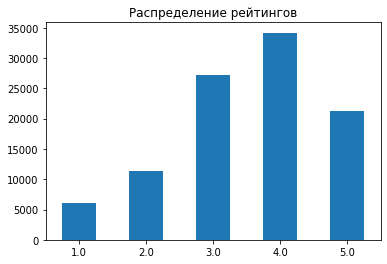

In [8]:
df["rating"].value_counts().sort_index().plot.bar(title="Распределение рейтингов", rot=0);

## Разбиение выборки на обучающую и тестовую

Библиотека **surprise** высокоуровневая, и позволяет нам разбить данные на обучающую и тестовую выборки всего одной функцией **train_test_split()**

In [9]:
from surprise.model_selection import train_test_split

Функция **train_test_split()** принимает на вход два параметра:
*  **data** - данные
*  **test_size** - доля тестовой выборки. Укажем 0,25, чтобы тестовая выборка составляла 25% от всей выборки.

In [10]:
trainset, testset = train_test_split(data, test_size=0.25)

# Задание 1

Проведите исследование данных (exploratory data analysis, EDA).

Выясните:

1. Сколько оценок в среднем поставил один человек (и какова выборочная дисперсия этой величины)
2. Сколько оценок в среднем имеет один фильм (+дисперсия)

Также для каждой из этих величин постройте гистограму (или violin plot) распределения чтобы увидеть картину целиком. Возможно вам понадобится использовать логарифмический масштаб осей (эту настройку можно передать в matplotlib).

In [11]:
df.head()

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


1. Сколько оценок в среднем поставил один человек (и какова выборочная дисперсия этой величины)

In [12]:
user_mean_count_rating = df.groupby(by='userId').agg({'rating': 'count'}).mean()[0]
user_var_count_rating = df.groupby(by='userId').agg({'rating': 'count'}).var()[0]
print(f"В среднем каждый человек поставил {round(user_mean_count_rating)} оценок, дисперсия - {round(user_var_count_rating)}")

В среднем каждый человек поставил 106 оценок, дисперсия - 10187


2. Сколько оценок в среднем имеет один фильм (+дисперсия)

In [13]:
movie_mean_count_rating = df.groupby(by='movieId').agg({'rating': 'count'}).mean()[0]
movie_var_count_rating = df.groupby(by='movieId').agg({'rating': 'count'}).var()[0]
print(f"В среднем каждый фильм имеет {round(movie_mean_count_rating)} оценок, дисперсия - {round(movie_var_count_rating)}")

В среднем каждый фильм имеет 59 оценок, дисперсия - 6462


## Построение простой модели

In [14]:
from surprise import SVD, KNNBasic, accuracy

Инициализируем алгоритм. Алгоритм SVD - один из самых распространенных методов матричной факторизации (представления матрицы в виде произведения нескольких матриц). Такое представление позволяет анализировать похожие матрицы и раскладывать их на так называемые "компоненты". А так же, восстанавливая матрицы их этих компонент - заполнять недостающие значения (в нашем случае - оценки). Почитать можно здесь: http://www.albertauyeung.com/post/python-matrix-factorization/

In [15]:
algo = SVD()

Тренируем на тренировочной выборке алгоритм.

In [16]:
algo.fit(trainset)

Делаем предсказание на тестовой выборке.

In [17]:
predictions = algo.test(testset)

In [18]:
testset

[('308', '367', 4.0),
 ('851', '144', 5.0),
 ('232', '172', 4.0),
 ('499', '902', 5.0),
 ('870', '693', 4.0),
 ('269', '42', 5.0),
 ('530', '204', 4.0),
 ('529', '325', 3.0),
 ('236', '135', 2.0),
 ('299', '127', 5.0),
 ('541', '83', 5.0),
 ('661', '566', 4.0),
 ('280', '942', 5.0),
 ('871', '904', 3.0),
 ('226', '275', 3.0),
 ('257', '121', 3.0),
 ('7', '182', 4.0),
 ('716', '472', 3.0),
 ('605', '405', 3.0),
 ('449', '70', 4.0),
 ('537', '640', 3.0),
 ('871', '1345', 3.0),
 ('892', '29', 2.0),
 ('334', '134', 5.0),
 ('344', '357', 5.0),
 ('887', '368', 5.0),
 ('899', '8', 4.0),
 ('650', '715', 3.0),
 ('43', '301', 5.0),
 ('405', '521', 4.0),
 ('16', '27', 2.0),
 ('647', '222', 4.0),
 ('597', '1016', 4.0),
 ('326', '153', 4.0),
 ('608', '288', 5.0),
 ('376', '197', 4.0),
 ('455', '259', 2.0),
 ('472', '826', 3.0),
 ('907', '143', 5.0),
 ('334', '203', 4.0),
 ('226', '7', 4.0),
 ('398', '95', 5.0),
 ('805', '1170', 5.0),
 ('699', '717', 1.0),
 ('561', '180', 4.0),
 ('667', '192', 5.0),

In [19]:
accuracy.rmse(predictions);

RMSE: 0.9371


## Кросс-валидация

Обучая любой алгоритм машинного обучения мы, фактически, "подгоняем" модель под данные, которые ей подаём. Но, если подгонять слишком сильно, то модель переобучится. То есть модель начнёт запоминать ответы вместо того, чтобы выявлять закономерности. 

На графиках ниже точки тренировочной выборки:
*  слева - недообученная модель (большая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)
*  посередине - хорошо обученная модель (маленькая ошибка на тренировочной выборке; маленькая ошибка на тестовой выборке)
*  справа - переобученная модель (очень маленькая или нулевая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)

<p align="center">
  <img src="https://drive.google.com/uc?id=1Eg4Xg4o-lhzrgqNNmNQCtB1RxNJmnmWx" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Таким образом, обучая модель, мы всегда уменьшаем ошибку на тренировочной выборке. Вместе с ошибкой на тренировочной выборке, падает и ошибка на тестовой. Но после какого-то момента, модель начинает переобучатся, и ошибка на тестовой выборке начинает расти, в то время, как ошибка на тренировочной выборке продолжает падать. 

<p align="center">
  <img src="https://drive.google.com/uc?id=1mvU_jJIe07tAoX82qODcpmTBctx0ReuT" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Может получится ситуация, когда мы видим маленькую ошибку нашей модели, и думаем, что она хорошая, но на самом деле она просто переобучилась, и на новых данных покажет плохой результат.

Чтобы избежать такой ситуации можно использовать отложенную выборку. То есть мы разбиваем наши данные на **тренировочную** выборку, **тестовую** выборку и **отложенную** выборку. Соответственно, обучаем модель на тренировочной, в ходе обучения проверяем результат на тестовой выборке, а в конце обучения, чтобы оценить качество модели, ошибку считаем на отложенной выборке.

При таком подходе в обучении модели участвует только тренировочная выборка. Тестовую и отложенную мы используем только для проверки. Если у нас мало данных, отложенная выборка - непозволительная роскошь. 

Другой популярный подход это **кросс-валидация** или скользящий контроль. Суть метода заключается в том, что мы дераем не одно разбиение датесета, а несколько разбиений таким образом, чтобы все данные использовались и в обучении и для проверки. Такие разбиения называются **фолдами**. 

Преимущества такого подхожа в том, что мы используем все данные для обучения. Также это позволяет оценить устойчивость модели. Если ошибки полученные на разных фолдах сильно отличаются, что модель неустойчива.
Недостаток метода в том, что нам нужно обучать не одну модель, а несколько (столько, сколько мы выбрали фолдов).

На практике часто выбирают 5 фолдов.

<p align="center">
  <img src="https://drive.google.com/uc?id=1C9eHgCi30X08XaSScmjqIOT3ayBtBiFw" alt="Drawing" style="width: 500px;" width="300"/>
</p>

In [20]:
from surprise.model_selection import cross_validate

Используем функцию **cross_validate** из модуля **model_selection** библиотеки **surprise**.

Функция принимает на вход:
*  algo - алгоритм, который будем обучать.
*  data - исходные данные. Обратите внимание, что данные передаём не разбитые на выборки.
*  measures - метрики ошибок по которым мы хотим сравнивать модели. Мы передаём среднеквадратичную ошибку и среднюю ошибку.
* cv - количество фолдов.
*  verbose - параметр указывающий хотим ли мы увидеть подробный результат выполнения функции.

In [21]:
algo = SVD()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9360  0.9371  0.9277  0.9409  0.9369  0.9357  0.0044  
MAE (testset)     0.7372  0.7381  0.7293  0.7421  0.7406  0.7374  0.0044  
Fit time          5.44    12.11   7.26    4.97    4.98    6.95    2.71    
Test time         0.32    0.51    0.30    0.33    0.36    0.36    0.08    


{'fit_time': (5.436666965484619,
  12.11166763305664,
  7.261872291564941,
  4.974773406982422,
  4.983389854431152),
 'test_mae': array([0.7371896 , 0.73807087, 0.72931675, 0.7420585 , 0.74056371]),
 'test_rmse': array([0.93601   , 0.93706096, 0.92765285, 0.94093015, 0.93692575]),
 'test_time': (0.32454991340637207,
  0.5138649940490723,
  0.2962343692779541,
  0.3269164562225342,
  0.3570125102996826)}

В результате получаем значения ошибок на каждом из фолдов, а также их среднее и стандартное отклонение (СО). Маленькое СО, как в нашем случае, говорит об устойчивости модели.

Дополнительно мы видим время тренировки и время предсказания модели на каждом из фолдов.

## Поиск по сетке (Grid search)

Теперь, когда у нас есть надёжный способ оценивать качество модели, мы можем перейти к подбору гиперпараметров модели, т.е. параметров, которые нужно указывать вручную, потому что нельзя обучить во время тренировки модели.

Метод поиска по сетке очень прост. Мы передаём варианты каждого из параметров, который мы хотим перебрать, а функция перебирает все возможные варианты переданных параметров. Например, на картинке ниже перебираются параметры "регуляризация" и "скорость обучения".

<p align="center">
  <img src="https://drive.google.com/uc?id=1xs9z_Zo1A2QinErKYEB-bp6eGnLWodbO" alt="Drawing" style="width: 700px;" width="700"/>
</p>

# Задание 2

## Часть 1

Оптимизируйте следующие параметры алгоритма SVD:

* n_epochs - количество эпох обучения
* lr_all - скорость обучения
* reg_all - регуляризация

Более детальное описание алгоритма смотри в [документации](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

P.S. не нужно делать слишком большую сетку перебора - если время расчёта отнимает больше 10 мин, то это уже очень много (для базового датасета).

In [22]:
from surprise.model_selection import GridSearchCV
import numpy as np

Для перебора по сетке используем функцию **GridSearchCV**. 
На вход подаём:
* алгоритм.
* параметры, которые хотим перебрать.
* метрики ошибок.
* количество фолдов для кросс-валидации.

Обратите внимание, что функция выполняет кросс-валидация автоматически.

In [23]:
param_grid_svd = {
    'n_epochs' : [10, 20],
    'lr_all' : [0.002, 0.005],
    'reg_all' : [0.04, 0.06]
}
grid_svd = GridSearchCV(SVD, param_grid_svd, cv=3, n_jobs=-1, measures=['rmse', 'mae'])
grid_svd.fit(data)
# best RMSE score
print(grid_svd.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(grid_svd.best_params['rmse'])
algo1 = grid_svd.best_estimator['rmse']
algo1.fit(data.build_full_trainset())
predictions = algo1.test(testset)

0.939599877806423
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.06}


In [24]:
accuracy.rmse(predictions);

RMSE: 0.8007


## Часть 2

Выберите другую модель из scikit surprise для предсказания рекомендаций (полный список смотри в [документации](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)).\
И настройте её параметры с помощью поиска по сетке.

Сравните результаты с предыдущей моделью.

In [25]:
param_grid_knn = {
    'n_epochs' : [10, 20],
    'lr_all' : [0.002, 0.005],
    'reg_all' : [0.04, 0.06]
}
grid_knn = GridSearchCV(KNNBasic, param_grid_knn, cv=3, n_jobs=-1, measures=['rmse', 'mae'])
grid_knn.fit(data)
# best RMSE score
print(grid_knn.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(grid_knn.best_params['rmse'])
algo2 = grid_knn.best_estimator['rmse']
algo2.fit(data.build_full_trainset())
predictions = algo2.test(testset)

0.9890743753055631
{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.04}
Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
accuracy.rmse(predictions);

RMSE: 0.7774


# Задание 3

С помощью натренированной модели (любой из предыдущих) постройте по 3 рекомендации для каждого клиента из тестовой выборки.

Проанализируйте полученные результаты: сколько раз был порекомендован каждый фильм? Каково распределение этих частот? (постройте гистограму)

In [27]:
testset[:5]

[('308', '367', 4.0),
 ('851', '144', 5.0),
 ('232', '172', 4.0),
 ('499', '902', 5.0),
 ('870', '693', 4.0)]

In [28]:
algo1.test(testset)[:5]

[Prediction(uid='308', iid='367', r_ui=4.0, est=3.6704110221637, details={'was_impossible': False}),
 Prediction(uid='851', iid='144', r_ui=5.0, est=4.313496823538793, details={'was_impossible': False}),
 Prediction(uid='232', iid='172', r_ui=4.0, est=4.267532928490846, details={'was_impossible': False}),
 Prediction(uid='499', iid='902', r_ui=5.0, est=4.159813855592278, details={'was_impossible': False}),
 Prediction(uid='870', iid='693', r_ui=4.0, est=3.483870999533846, details={'was_impossible': False})]

In [29]:
df[df['userId'] == '236']

,userId,movieId,rating,timestamp
416,236,71,3.0,890116671
674,236,632,3.0,890116254
761,236,57,5.0,890116575
2356,236,265,2.0,890116191
2467,236,313,4.0,890115777
...,...,...,...,...
87321,236,717,3.0,890117409
91154,236,521,3.0,890115996
92616,236,520,4.0,890116095
94102,236,411,1.0,890117095


In [30]:
algo1.predict('236', '1013', verbose=True)

user: 236        item: 1013       r_ui = None   est = 2.18   {'was_impossible': False}


Prediction(uid='236', iid='1013', r_ui=None, est=2.175686851089898, details={'was_impossible': False})

In [31]:
users = pd.DataFrame(testset)[0].unique()
movies = pd.DataFrame(testset)[1].unique()
users.shape, movies.shape

((943,), (1452,))

In [32]:
predictions = pd.DataFrame(0., index=movies, columns=users)

In [33]:
for user in users:
    for movie in movies:
        predictions.loc[movie, user] = float(algo1.predict(user, movie)[3])
predictions

,308,851,232,499,870,269,530,529,236,299,541,661,280,871,226,257,7,716,605,449,537,892,334,344,887,899,650,43,405,16,647,597,326,608,376,455,472,907,398,805,...,155,581,424,68,824,300,895,598,672,322,511,866,549,575,319,762,485,120,816,384,754,725,513,578,414,27,855,400,797,86,261,818,179,822,482,431,132,564,685,111
367,3.670411,3.546780,3.518262,3.448468,3.386522,2.921234,3.652287,3.860884,3.379027,3.366708,3.850639,3.729173,3.747110,3.382852,3.409928,3.938280,3.862080,3.718557,3.583294,3.619692,2.819972,3.935386,3.465948,3.565039,4.044447,3.351427,3.072420,3.709828,1.782648,4.047707,3.812087,3.691179,3.094115,3.498961,3.575965,3.451792,4.636972,4.547233,3.407849,3.630436,...,3.068164,3.661408,3.490998,3.163331,3.140449,4.149182,3.691235,3.735038,3.434741,3.732044,3.954110,2.696101,3.761450,2.776037,3.497595,3.121474,3.157529,3.461225,4.262450,4.167047,3.315426,3.896746,4.296273,2.974815,3.814457,3.311414,3.216680,3.758207,2.961797,3.659875,4.426116,3.529898,3.048369,3.321918,3.534530,3.622749,3.495795,3.601351,2.463764,3.515911
144,3.916248,4.313497,3.801200,3.720534,3.698875,2.751074,3.934531,4.212961,3.286661,3.673894,4.261125,4.038005,3.702115,3.963201,3.899307,4.089416,4.393776,3.754425,3.859949,3.838642,3.151939,4.338042,3.661792,3.822170,4.201488,3.731554,3.499655,4.255717,2.966074,4.718882,4.081530,3.908155,3.637554,3.721111,3.800091,3.866590,4.821321,4.886042,4.000685,3.399432,...,3.531245,4.115136,3.655861,3.327608,3.307874,4.325715,4.165865,4.117023,3.591773,4.315187,4.299003,2.937917,3.960227,3.105374,4.006151,3.585090,3.435917,3.936305,4.540068,4.337395,3.854343,4.134320,4.560576,3.297965,4.107856,3.777510,3.426300,4.228698,3.373539,3.922447,4.650006,3.993951,3.757384,3.629734,3.878529,3.870267,3.741313,3.729503,2.857545,3.869775
172,4.318024,4.421256,4.267533,4.055102,4.050888,3.156551,4.057243,4.559977,3.633098,3.973058,4.638396,4.383297,4.192684,4.305361,4.165647,4.365132,4.679828,4.398522,4.210626,4.270875,3.362205,4.572155,3.981652,4.238232,4.535503,4.063077,3.844121,4.549264,3.258329,4.997876,4.336533,4.376929,3.779186,3.631847,3.966393,4.132639,4.871752,5.000000,4.221176,3.771368,...,3.914742,4.411354,3.845127,3.899120,3.849411,4.600269,4.534098,4.488180,3.851915,4.440379,4.649777,3.250881,4.437526,3.536375,4.234852,3.778111,3.815819,4.310350,4.743035,4.694605,4.018473,4.476108,4.929782,3.474038,4.451559,4.193225,3.752116,4.413397,3.948795,4.459457,4.995954,4.170593,3.895527,3.760579,4.083451,4.125755,4.046636,4.015205,3.203023,4.060639
902,3.967274,3.985893,3.907013,4.159814,3.690329,3.852460,3.940484,4.113038,3.658730,3.676464,3.939953,3.909317,4.126073,3.805381,3.887909,4.339737,4.211787,3.956992,4.070148,3.986549,3.194649,4.141514,3.812028,3.912103,4.655603,3.659283,3.569043,3.981530,2.234761,4.198509,4.123094,4.180287,3.589860,3.619472,3.842880,3.592523,4.824950,4.888032,3.716518,3.827812,...,3.456344,3.949521,3.702939,3.457838,3.479656,4.338346,4.127536,4.022531,4.070117,3.925081,4.256465,3.030749,4.109035,3.462100,3.797557,3.297744,3.516790,4.069609,4.439528,4.461370,3.979414,4.127071,4.526107,3.103639,4.230197,3.746827,3.404015,4.097003,3.287265,4.112241,4.701130,3.752482,2.853518,3.483172,3.948006,3.933197,3.592879,4.002543,2.790711,3.575562
693,3.932230,4.060089,3.758413,3.662325,3.483871,3.510752,3.679864,3.861451,3.369750,3.500905,3.889559,3.770501,3.661871,3.502201,3.617594,4.040526,4.192626,3.683858,4.004278,3.826074,3.241505,4.088430,3.614215,3.838401,3.794758,3.412777,3.244884,3.804919,1.865722,4.283295,3.761106,3.683067,3.177170,3.538664,3.542972,3.578228,4.445161,4.501092,3.665835,3.861201,...,3.112207,4.076911,3.393952,3.303100,3.309189,4.319060,3.922698,3.835583,3.497978,4.006218,4.175259,2.819152,3.826207,2.968654,3.610881,3.226831,3.264169,3.654845,4.162169,4.144428,3.764743,3.981411,4.356246,2.973102,3.864281,3.491117,3.336215,3.784854,2.953383,3.717953,4.512552,3.560070,3.338360,3.358188,3.629540,3.708749,3.477270,3.586826,2.650079,3.592077
...,...,...,...,...,...,...,...,...,...,..

In [34]:
predictions['236'].astype(float)

367     3.379027
144     3.286661
172     3.633098
902     3.658730
693     3.369750
          ...   
18      2.807849
992     2.930402
1335    2.830082
1628    3.533441
1458    3.012917
Name: 236, Length: 1452, dtype: float64

In [36]:
df_movies = pd.DataFrame(0, index=movies, columns=['count'])
for user in users:
    for movie in predictions.astype(float).nlargest(3, user).index.values:
        df_movies.loc[movie, 'count'] = df_movies.loc[movie, 'count'] + 1
df_movies.head()

,count
367,0
144,2
172,15
902,2
693,0


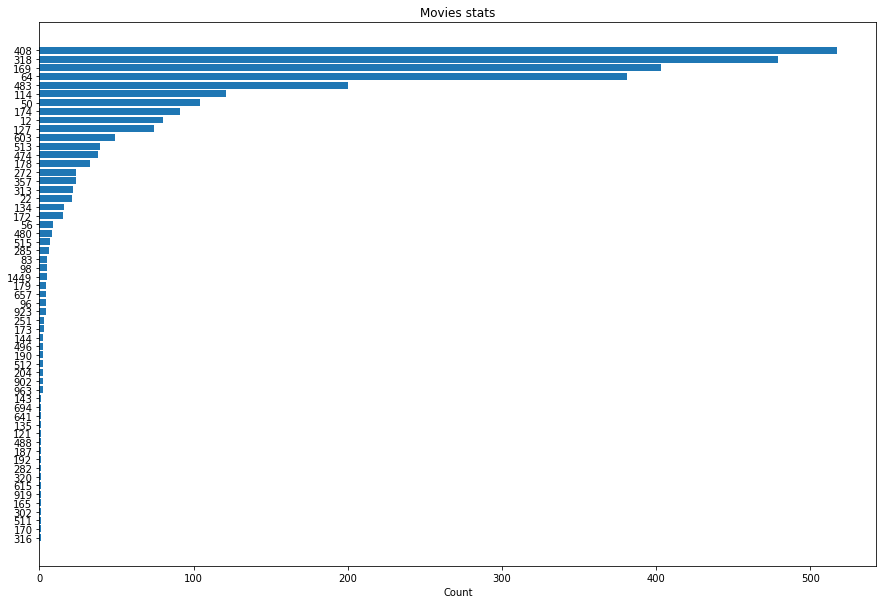

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.barh(df_movies[df_movies['count']>0].sort_values(by='count').index,
         df_movies[df_movies['count']>0].sort_values(by='count')['count'])
plt.xlabel('Count')
plt.title('Movies stats')
plt.show()

# Задание 4 * (Дополнительное)

В оригинальных данных есть поле `timestamp` (см. момент загрузки данных).

Используя оптимальный вариант модели (и её гиперпараметров), найденный выше, проведите кросс-валидацию в стиле временного ряда (см. [документацию sklearn](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)). Достаточно использовать 5 частей. Иными словами, нужно раделить выборку на равные части, каждая из которых будет соответствовать последовательным временным промежуткам.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

Нашли ли вы отличия с предыдущей валидацией?

In [53]:
# Ваш код тут